In [1]:
import numpy as np
from typing import List
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, TensorDataset
from ae import AutoEncoder
from wdgrl import WDGRL

In [2]:
def gen_data(mu: float, delta: List[int], n: int, d: int, alpha: float = 0.05):
    mu = np.full((n, d), mu, dtype=np.float64)
    noise = np.random.normal(loc=0, scale=1, size=(n, d))
    X = mu + noise
    labels = np.zeros(n)
    # 5% of the data is abnormal.
    # Anomalies are generated by randomly adding deltas to the data.
    n_anomalies = min(20, int(n * alpha))
    idx = np.random.choice(n, n_anomalies, replace=False)
    if 0 in delta:
        delta.pop(delta.index(0))
    if len(delta) == 0:
        return X, labels
    split_points = sorted(
        np.random.choice(range(1, len(idx)), len(delta) - 1, replace=False)
    )
    segments = np.split(idx, split_points)
    for i, segment in enumerate(segments):
        X[segment] = X[segment] + delta[i]
    labels[idx] = 1
    return X, labels

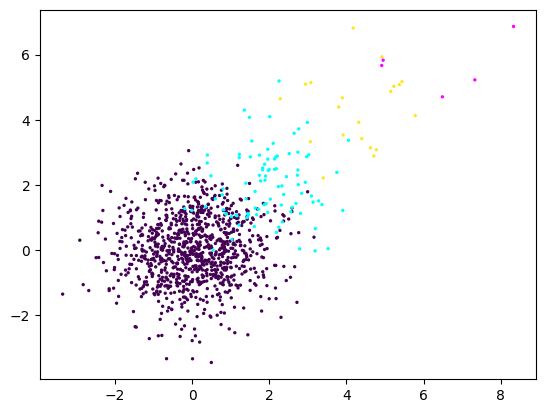

In [3]:
"""Create synthetic dataset and dataloaders for domain adaptation."""
# Create datasets
ns, nt, d = 1000, 100, 32

xs, ys = gen_data(0, [4], ns, d)
xt, yt = gen_data(2, [4], nt, d)

plt.scatter(xs[:, 0], xs[:, 1], c=ys, cmap="viridis", s=2)
plt.scatter(xt[:, 0], xt[:, 1], c=yt, cmap="cool", s=2)
plt.show()

In [4]:
batch_size = 16

xs = torch.FloatTensor(xs)
ys = torch.LongTensor(ys)
xt = torch.FloatTensor(xt)
yt = torch.LongTensor(yt)

source_dataset = TensorDataset(xs, ys)
target_dataset = TensorDataset(xt, yt)

source_loader = DataLoader(
    source_dataset, batch_size=batch_size, shuffle=True, drop_last=True
)
target_loader = DataLoader(
    target_dataset, batch_size=batch_size, shuffle=True, drop_last=True
)

In [5]:
WDGRL_model = WDGRL(
    input_dim=d, generator_hidden_dims=[500, 100], critic_hidden_dims=[100]
)

AE_model = AutoEncoder(
    input_dim=100, encoder_hidden_dims=[16, 8, 4, 2], decoder_hidden_dims=[2, 4, 8, 16]
)

In [6]:
num_epochs = 5
losses, source, target = WDGRL_model.train(
    source_loader=source_loader,
    target_loader=target_loader,
    num_epochs=num_epochs,
    dc_iter=50,
)

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch\autograd\graph.py:829: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\cuda\CublasHandlePool.cpp:179.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
Epoch:  20%|██        | 1/5 [00:02<00:08,  2.15s/it]

Epoch 1/5 | Loss: 166.87288198163432
--------------------------------


Epoch:  40%|████      | 2/5 [00:04<00:06,  2.01s/it]

Epoch 2/5 | Loss: 67.16037971742692
--------------------------------


Epoch:  60%|██████    | 3/5 [00:06<00:04,  2.05s/it]

Epoch 3/5 | Loss: 53.51298572171119
--------------------------------


Epoch:  80%|████████  | 4/5 [00:08<00:01,  1.98s/it]

Epoch 4/5 | Loss: 37.15325189405872
--------------------------------


Epoch: 100%|██████████| 5/5 [00:10<00:00,  2.00s/it]

Epoch 5/5 | Loss: 21.66678237915039
--------------------------------


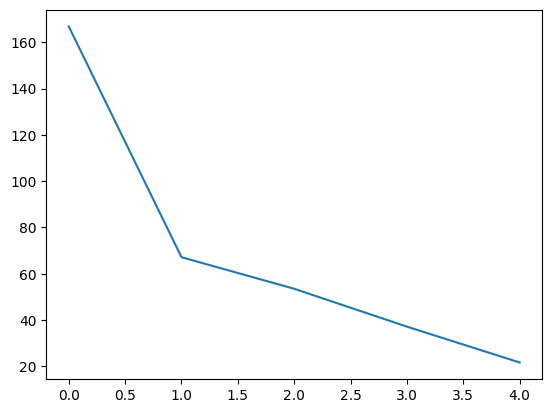

In [7]:
plt.plot(losses)

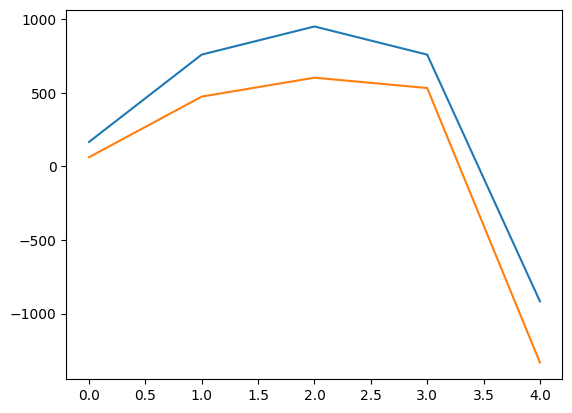

In [8]:
plt.plot(source)
plt.plot(target)
plt.show()

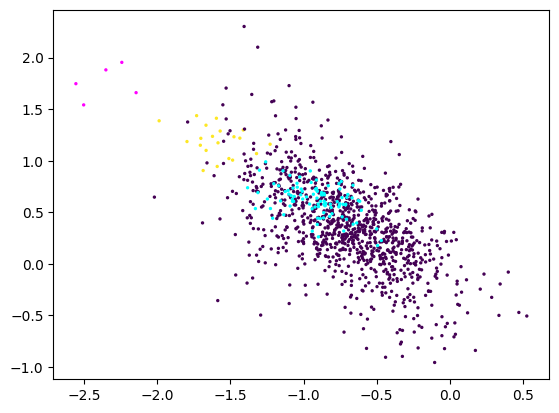

In [9]:
xs_hat = WDGRL_model.extract_feature(xs.cuda())
xt_hat = WDGRL_model.extract_feature(xt.cuda())
xs_hat = xs_hat.cpu().numpy()
xt_hat = xt_hat.cpu().numpy()

plt.scatter(xs_hat[:, 0], xs_hat[:, 1], c=ys, cmap="viridis", s=2)
plt.scatter(xt_hat[:, 0], xt_hat[:, 1], c=yt, cmap="cool", s=2)
plt.show()

In [11]:
x_hat = np.concatenate((xs_hat, xt_hat), axis=0)
x_hat = torch.tensor(x_hat, dtype=torch.float32)

batch_size = 32
num_epochs = 5

x_hat_dataset = TensorDataset(x_hat)
x_hat_data_loader = torch.utils.data.DataLoader(
    x_hat_dataset, batch_size=batch_size, shuffle=True
)

losses = AE_model.train(x_hat_data_loader, num_epochs=num_epochs)

Epoch 1/5 | Loss: 0.025789953768253326
Epoch 2/5 | Loss: 0.014982710592448711
Epoch 3/5 | Loss: 0.007455704268068075
Epoch 4/5 | Loss: 0.005861439276486635
Epoch 5/5 | Loss: 0.0056727067567408085


In [13]:
torch.save(WDGRL_model.generator.state_dict(), "weights/feature_extractor.pth")
torch.save(AE_model.state_dict(), "weights/autoencoder.pth")